In [1]:
sys.path.append('C:/Users/nyasha/Desktop/Masters-Nyasha/Models')

import sys

import torch
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from DatasetCreator import HAVSDataset

from CAE import *
from training_functions import *

In [2]:
BATCH_SIZE = 128
NUM_EPOCHS = 25

In [3]:
compressed_file_path = "C:/Users/nyasha/Desktop/Masters-Nyasha/Processed Data/processed_data.npz"
x_train, x_test, x_val, y_train, y_test, y_val = get_train_test_data(compressed_file_path)

In [5]:
# Check if files have been imported correctly
print(x_train.shape)  
print(x_test.shape)
print(x_val.shape)
print(y_train.shape) 
print(y_test.shape)
print(y_val.shape)

(22416, 128, 128)
(7472, 128, 128)
(7472, 128, 128)
(22416,)
(7472,)
(7472,)


In [10]:
# Check if type is correct
print(type(x_train))  
print(type(x_test))
print(type(x_val))
print(type(y_train)) 
print(type(y_test))
print(type(y_val))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [6]:
# Define the transforms
transform = transforms.Compose(
    [
     transforms.ToTensor()
    ])

In [7]:
train_dataset = HAVSDataset(x_train, y_train, transform=transform)
val_dataset = HAVSDataset(x_val, y_val, transform=transform)
test_dataset = HAVSDataset(x_test, y_test, transform=transform)

In [8]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        ## encoder layers ##

        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2) 
    
        self.conv2 = nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        # add second hidden layer
        """"
        x = F.relu(self.conv2(x))
        x = self.pool2(x)  # compressed representation
        """

        return x

class Decoder(nn.Module):
    def __init__(self):

        super(Decoder, self).__init__()
        self.dconv1 = nn.ConvTranspose2d(16, 32, 3, padding=1, stride=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.dconv2 = nn.ConvTranspose2d(32, 1, 3, padding=1, stride=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, encode):
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.dconv1(encode))
        x = self.upsample1(x)

        x = F.relu(self.dconv2(x))
        x = self.upsample2(x)
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(x)

        return x

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, img):
        x = self.encoder(img)
        x = self.decoder(x)
        
        return x


In [52]:
model_1  = CAE_2()
print(model_1)

CAE_2(
  (encoder): Encoder_2(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Decoder_2(
    (deconv3): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (deconv2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (deconv1): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [53]:
pytorch_total_params_model_1 = sum(p.numel() for p in model_1.parameters())
print(f"The number of  parameters in this model is {pytorch_total_params_model_1}")

The number of  parameters in this model is 3913


In [54]:
device = get_device()
model_on_device = model_1.to(device) # Move model to device

Running on the GPU


In [55]:
# specify loss function
criterion = nn.BCELoss()

# specify optimizer
optimizer = torch.optim.SGD(model_on_device.parameters(), lr=0.01)

In [56]:
train_cae(50, train_loader, criterion, optimizer, device, model_on_device)

Epoch: 1 	Training Loss: 89.031554
Epoch: 2 	Training Loss: 87.656052
Epoch: 3 	Training Loss: 87.487068
Epoch: 4 	Training Loss: 87.412151
Epoch: 5 	Training Loss: 87.368925
Epoch: 6 	Training Loss: 87.340703
Epoch: 7 	Training Loss: 87.320117
Epoch: 8 	Training Loss: 87.304931
Epoch: 9 	Training Loss: 87.293785
Epoch: 10 	Training Loss: 87.283409
Epoch: 11 	Training Loss: 87.275799
Epoch: 12 	Training Loss: 87.268863
Epoch: 13 	Training Loss: 87.263055
Epoch: 14 	Training Loss: 87.257252
Epoch: 15 	Training Loss: 87.252998
Epoch: 16 	Training Loss: 87.248748
Epoch: 17 	Training Loss: 87.245652
Epoch: 18 	Training Loss: 87.242195
Epoch: 19 	Training Loss: 87.239189
Epoch: 20 	Training Loss: 87.236069
Epoch: 21 	Training Loss: 87.234101
Epoch: 22 	Training Loss: 87.231283
Epoch: 23 	Training Loss: 87.229775
Epoch: 24 	Training Loss: 87.227130
Epoch: 25 	Training Loss: 87.225264
Epoch: 26 	Training Loss: 87.223451
Epoch: 27 	Training Loss: 87.221379
Epoch: 28 	Training Loss: 87.220203
E

Original Images


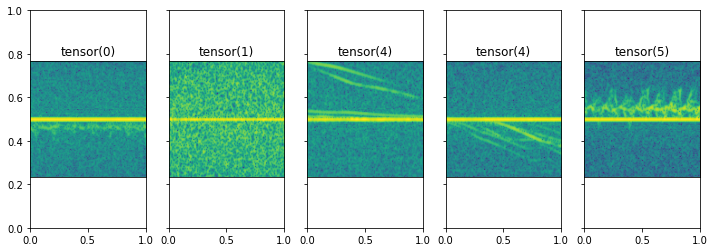

Reconstructed Images


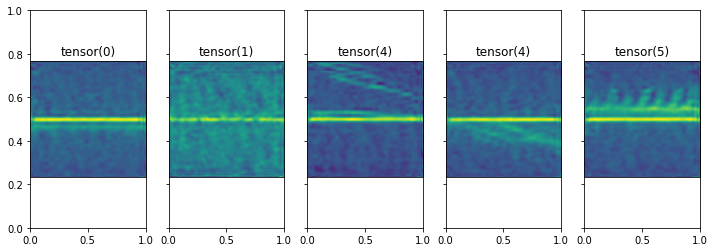

In [59]:
 visualise_cae_performance(train_loader, device, model_on_device, 128, 128, 128)

In [69]:
net = model_on_device
net

CAE_2(
  (encoder): Encoder_2(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Flatten()
    (1): Linear(in_features=8192, out_features=6, bias=True)
    (2): ReLU()
    (3): Softmax(dim=1)
  )
)

In [61]:
# Freeze model weights
for param in net.parameters():
    param.requires_grad = False

In [62]:
# Remove convolutional transpose layer
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device, dtype=torch.float)
net2 = nn.Sequential(*list(model_on_device.children())[:-1])
net2(images).shape

torch.Size([128, 8, 32, 32])

In [63]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

In [64]:
net2.add_module('flatten', Flatten())
net2(images.cuda()).shape

torch.Size([128, 8192])

In [65]:
net.decoder = nn.Sequential(
    Flatten(),
    nn.Linear(8192, 6),
    nn.ReLU(),
    nn.Softmax(dim=1)
)

In [67]:
import torch.optim as optim
net = net.to(device)
class_weights = get_class_weights(y_train, device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adamax(net.parameters(), lr=0.01)

C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['2_walking' 'clutter/noise' 'running' 'sphere_swing' 'vehicle' 'walking'], y=['walking' 'walking' 'vehicle' ... 'running' 'clutter/noise' 'vehicle'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [68]:
train_model(50, train_loader, criterion, optimizer, device, model_on_device)


Epoch: 1/50 	 Training Loss: 2.5353814670816064, Accuracy: 28.336902212705212
Epoch: 2/50 	 Training Loss: 2.514462435618043, Accuracy: 29.826909350463954
Epoch: 3/50 	 Training Loss: 2.443527491763234, Accuracy: 35.13561741613133
Epoch: 4/50 	 Training Loss: 2.4112669872120023, Accuracy: 37.16095645967167
Epoch: 5/50 	 Training Loss: 2.4126566061750054, Accuracy: 37.905960028551036
Epoch: 6/50 	 Training Loss: 2.3837387934327126, Accuracy: 39.168451106352606
Epoch: 7/50 	 Training Loss: 2.2886176351457834, Accuracy: 46.99768022840828
Epoch: 8/50 	 Training Loss: 2.2427194342017174, Accuracy: 48.51891506067095
Epoch: 9/50 	 Training Loss: 2.247268622741103, Accuracy: 49.11670235546038
Epoch: 10/50 	 Training Loss: 2.2255582502111793, Accuracy: 49.594039971448964
Epoch: 11/50 	 Training Loss: 2.228565987199545, Accuracy: 49.45574589578872
Epoch: 12/50 	 Training Loss: 2.221298646181822, Accuracy: 49.62972876516774
Epoch: 13/50 	 Training Loss: 2.2558704847469926, Accuracy: 49.6297287651

KeyboardInterrupt: 

In [75]:
x = [1, 2]
c = x
x.pop()
print(c)

[1]


In [70]:
model_on_device.eval() # Turn off dropout, batch norm etc
# model_on_device.train() # To turn back to training
evaluate_model(test_loader, device, net)

# make sure that when you freeze the network, the network has learnt a lot of diverse data

NameError: name 'evaluate_model' is not defined

In [58]:
train_model(NUM_EPOCHS, train_loader, criterion, optimizer, device, model_on_device)

Epoch: 1/1 	 Training Loss: 1.8935127835720778, Accuracy: 72.85421127765882
